In [1]:
# imports
import numpy as np
import krakenex as k
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import time
import datetime
from pathlib import Path
import sys
from datetime import datetime, timedelta
from matplotlib import dates 
import IPython.core.debugger
dbg = IPython.core.debugger.Pdb()
#dbg.set_trace() #colocar dondo punto interrupcion
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import time
start = time.time()


In [2]:
#set SQL BBDD
from sqlalchemy import create_engine, MetaData, Table, Column, DateTime, Float, String,Integer

dbInstance = 'sqlite:///krakenTeader.db'
dbBalanceHistoryTable = 'BalanceHistory'
dbTradesHistoryTable = 'TradesHistory'
dbMyHistoryTable = 'MyTrades'
engine = create_engine(dbInstance)

if not engine.dialect.has_table(engine, dbMyHistoryTable):  # If table don't exist, Create.
    metadata = MetaData(engine)
    
    # Create a table with the appropriate Columns
    Table(dbMyHistoryTable, metadata,
             Column('id', Integer, nullable=True), 
             Column('openTime', DateTime, nullable=True), 
             Column('closeTime', DateTime, nullable=True), 
             Column('tradeDescription', String, nullable=True), 
             Column('openingCH', Float, nullable=True), 
             Column('baseCH', Float, nullable=True), 
             Column('targetCH', Float, nullable=True), 
             Column('stopLoseCH', Float, nullable=True), 
             Column('TotalLoseCH', Float, nullable=True), 
             Column('closingCH', Float, nullable=True), 
             Column('deltaCH', Float, nullable=True), 
             Column('Profit', Float, nullable=True))
    # Implement the creation
    metadata.create_all() 

In [3]:
#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

print(BalanceHistory.index.min())
print(BalanceHistory.index.max())

2017-10-11 23:43:07.913669
2017-11-24 01:00:52.038814


In [4]:

#preparar datos para plotear
BalanceHistory = pd.read_sql(dbBalanceHistoryTable, con=engine)
BalanceHistory = BalanceHistory.set_index(pd.DatetimeIndex(BalanceHistory['Time']))
BalanceHistory.drop('Time', axis=1,inplace=True)

#filtrar periodo de interes
windowTime = (24 * 43) 
EndSampleTime = datetime(2017,11,22,0,0)
plotmin = True
HoursInterval = 1
if windowTime > 6: plotmin = False
if windowTime > 12: HoursInterval = 2
if windowTime > 24: HoursInterval = 4
if windowTime > 24 * 2: HoursInterval = 8
if windowTime > 24 * 5: HoursInterval = 12
if windowTime > 24 * 10: HoursInterval = 24
if windowTime > 24 * 15: HoursInterval = 48

verUltimo=False

if verUltimo:
    startSampleTime = datetime.now() + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[BalanceHistory.index > startSampleTime]
else:
    startSampleTime = EndSampleTime + timedelta(hours=windowTime*-1)
    BalanceHistory = BalanceHistory[(BalanceHistory.index >= startSampleTime) & (BalanceHistory.index <= EndSampleTime)]

#combertir el balance a un porcentaje entre -100% y 100%
BalanceHistory['balanceRatio'] = (BalanceHistory['balanceRatio'] - 0.5 )*2*100 

BalanceHistory['volbuy'] = BalanceHistory['volbuy'] / BalanceHistory['close']
BalanceHistory['volsell'] = BalanceHistory['volsell'] / BalanceHistory['close']
BalanceHistory['unbalance'] = BalanceHistory['unbalance'] / BalanceHistory['close']

#calcular %CH, %CH Acum , SMA %CH Acum
BalanceHistory['change'] = BalanceHistory['close'].pct_change(periods=1)*100
#BalanceHistory['cahnge2'] = BalanceHistory['close'] / BalanceHistory['close'].shift(1) -1 #equibalente 
BalanceHistory['cum_change'] = BalanceHistory['change'].cumsum()
BalanceHistory['SMA03_cum_change'] = BalanceHistory['cum_change'].rolling(5).mean()
BalanceHistory['SMA12_cum_change'] = BalanceHistory['cum_change'].rolling(12).mean()

#calcular sma de 3 periodos (suavisar el grafico)
BalanceHistory['EWM_unbalance'] =  BalanceHistory["unbalance"].ewm(span=3).mean()

#calcular la porsiocn negativa (para mostrar en rojo en el grafico)
BalanceHistory['EWM_unbalance_N'] = BalanceHistory['EWM_unbalance']
neg = BalanceHistory['EWM_unbalance_N']
neg[neg >= 0] = np.nan
BalanceHistory['EWM_unbalance_N'] = neg


comCompra = 0.29  
comVenta = 0.19 
spreadEntrada = 0.2 
spreadSalida = 0.2
deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

In [5]:
def Condensatetrades():
    
    tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
    tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)

    tradesCondensation =  pd.DataFrame(columns=['time','price','countb','volb','counts','vols'])

    if (len(tradesHistory) > 0) & (len(BalanceHistory) > 0):
        for i in range(len(BalanceHistory)):
            if i > 0:
                t0 = BalanceHistory.index[i]
                t1 = BalanceHistory.index[i-1]

                trades0 = tradesHistory[t1:t0]

                trades0b = trades0[trades0['buy_sell'] =='b']
                trades0s = trades0[trades0['buy_sell'] =='s']

                tradesCountb = len(trades0b)
                tradesCounts = len(trades0s)*-1

                price = trades0.price.mean()

                volb = trades0b.volume.sum()
                vols = trades0s.volume.sum()*-1

                new = [t0,price,tradesCountb,volb,tradesCounts,vols]
                tradesCondensation.loc[len(tradesCondensation)] = new
        #end for
        if (len(tradesCondensation) > 0):
            tradesCondensation.fillna(0,inplace=True)
            tradesCondensation.set_index(pd.DatetimeIndex(tradesCondensation['time']),inplace=True)
            tradesCondensation.drop('time',inplace=True,axis=1)

    return tradesCondensation

In [6]:
tradesCondensation = Condensatetrades()

In [7]:
def restarGastos (s):
    l = []
    for i in range(len(s)):
            l.append((s[i+1] - (deltaBaseCH*(i+1)) ))
    return l

def plotProfit():
    if len(myTrades) > 0:
        myTrades['Profit'] = myTrades['deltaCH'].cumsum()
        myTrades['Profit_Gastos'] = restarGastos(myTrades['Profit'])
        totalCom = len(myTrades) * deltaBaseCH
        totalWin = myTrades.deltaCH.sum()
        finalBalance = totalWin - totalCom
        print('total win: {0}, total commiciones: {1}, Balance Final {2}'.format( totalWin,totalCom,finalBalance))
        if len(myTrades) > 1:
            myTrades['Profit'].plot()   
            myTrades['Profit_Gastos'].plot()

In [8]:
def plotHistory(plotVolume=False, plotTrades=False):
    fig,ax = plt.subplots( sharex=True, figsize=(16,14), nrows=4, ncols=1)

    #plot price
    ax[0].plot_date(BalanceHistory.index, BalanceHistory['close'],'orange',marker='o', markersize=1)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[0].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[0].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[0].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[0].set_title('CLOSE')
    ax[0].legend(loc='best')

    #plot %CH short SMA Large SMA
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['change'],'ro-', markersize=1)
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['cum_change'],'b-')
    ax[1].plot_date(BalanceHistory.index, BalanceHistory['SMA03_cum_change'],'go-', markersize=1,alpha=0.6) #ligthBlue
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[1].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[1].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[1].set_title('% CHANGE - CUMULATIVE CHANGE')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='g',ls='-')

    #plot  MarquetBalance
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volbuy'],'g--',alpha=0.5)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['volsell'],'r--',alpha=0.5) 
    #ax[2].plot_date(BalanceHistory.index, BalanceHistory['unbalance'],'bo-', markersize=3)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance'],'bo-', markersize=1)
    ax[2].plot_date(BalanceHistory.index, BalanceHistory['EWM_unbalance_N'],'ro-', markersize=1)

    ax[2].yaxis.grid(True) 
    ax[2].xaxis.grid(True) 
    ax[2].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
    ax[2].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
    if plotmin ==True:
        ax[2].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
        ax[2].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
        ax[2].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

    ax[2].set_title('volbuy - volsell- unbalance')
    ax[2].legend(loc='best')
    #ax[2].axhline(0,color='g',ls='-')

    # plot volumen
    if plotVolume == True:
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['volb'],'g',marker='o', markersize=3)
        ax[3].plot_date(tradesCondensation.index, tradesCondensation['vols'],'r',marker='o', markersize=3)
        ax[3].yaxis.grid(True) 
        ax[3].xaxis.grid(True) 
        ax[3].xaxis.set_major_locator(dates.HourLocator(interval=HoursInterval)) 
        ax[3].xaxis.set_major_formatter(dates.DateFormatter('\n %d-%m %H'))
        if plotmin ==True:
            ax[3].xaxis.set_minor_locator(dates.MinuteLocator(interval=5))
            ax[3].xaxis.set_minor_formatter(dates.DateFormatter('%M'))
            ax[3].xaxis.grid(b=True, which='minor', color='grey', linestyle='--')

        ax[3].set_title('VOLUMEN POR PERIODO')
        ax[3].legend(loc='best')
        ax[3].axhline(0,color='g',ls='-')

    if plotTrades == True:
        cont = 1
        for d in  myTrades.openTime:        
            ax[1].annotate(cont , xy=(d,1))
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#05652F",linewidth=2,zorder=0, clip_on=False)
            cont += 1

        for d in myTrades.closeTime:
            ax[0].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[1].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[2].axvline(d,ymin=-1.2,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)
            ax[3].axvline(d,ymin=0,ymax=1,c="#ffaa80",linewidth=2,zorder=0, clip_on=False)


In [9]:
def plotAllTrades():
    tradesCount = len(myTrades)
    if tradesCount > 0:
        fig, axes = plt.subplots(tradesCount, 2, figsize=(16,tradesCount*5), squeeze=False)
        for i in range(tradesCount):
            n = i+1
            row = axes[i]
            dOpen = myTrades.openTime[n]
            iniPos = BalanceHistory.index.get_loc(dOpen)-5
            iniMoment = BalanceHistory.index[iniPos] 

            sDesc = myTrades.tradeDescription[n]
            
            dClose = myTrades.closeTime[n]
            endPos = BalanceHistory.index.get_loc(dClose)+5
            maxPos  = len(BalanceHistory)
            if endPos >= maxPos:
                endPos = maxPos-1
            
            endMoment = BalanceHistory.index[endPos] 
            
            df =  BalanceHistory[(BalanceHistory.index >= iniMoment) & (BalanceHistory.index <= endMoment)]

            #calcular %CH, %CH Acum , SMA %CH Acum
            #df['change'] = df['close'].pct_change(periods=1)*100
            #df['cum_change'] = df['change'].cumsum()
            #df['SMA03_cum_change'] = df['cum_change'].rolling(3).mean()
            #df['SMA12_cum_change'] = df['cum_change'].rolling(12).mean()
            plotTrade(row, df,dOpen, dClose, sDesc,myTrades.openingCH[n],myTrades.closingCH[n])

        fig.autofmt_xdate() 
        plt.legend() 
        plt.tight_layout() 
        plt.show()
    else:
        print('No trades for plot')

def plotTrade(ax, df, dOpen, dClose, sDesc, openCH,closeCH):
    intervalo = int(HoursInterval/4)
    if intervalo == 0: intervalo = 1
    locator = mdates.HourLocator(interval=intervalo)
    locator.MAXTICKS = 10000

    ax[0].plot_date(df.index, df['volbuy'],'g--',alpha=0.5)
    ax[0].plot_date(df.index, df['volsell'],'r--',alpha=0.5)
    ax[0].plot_date(df.index, df['unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance'],'bo-', markersize=3)
    #ax[0].plot_date(df.index, df['EWM_unbalance_N'],'ro-', markersize=3)
    ax[0].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[0].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    ax[0].yaxis.grid(True) 
    ax[0].xaxis.grid(True) 
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[0].yaxis.set_major_locator(mticker.AutoLocator())
    ax[0].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[0].legend(loc='best')
    ax[0].axhline(0,color='g',ls='-')
    ax[0].set_title(sDesc)

    ax[1].plot_date(df.index, df['cum_change']- openCH,'b-')
    ax[1].plot_date(df.index, df['SMA03_cum_change']- openCH,'go-', markersize=2,alpha=0.8)
    ax[1].plot_date(df.index, df['SMA12_cum_change'] - openCH,'o-',color='#3366ff', markersize=2,alpha=0.8) #ligthBlue
    ax[1].axvline(dOpen,ymin=-0,ymax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axvline(dClose,ymin=-0,ymax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].axhline(openCH - openCH,xmin=-0,xmax=1,c="#05652F",linewidth=2,zorder=0)
    ax[1].axhline(closeCH - openCH,xmin=-0,xmax=1,c="#F44C04",linewidth=2,zorder=0)
    
    ax[1].yaxis.grid(True) 
    ax[1].xaxis.grid(True) 
    ax[1].xaxis.set_major_locator(locator)
    ax[1].xaxis.set_major_formatter(dates.DateFormatter('%d %H'))
    ax[1].yaxis.set_major_locator(mticker.AutoLocator())
    ax[1].xaxis.grid(b=True, which='mayor', color='grey', linestyle='--')
    ax[1].legend(loc='best')
    ax[1].axhline(0,color='b',ls='-')

In [10]:
def obtenerMaximo(m,ch):
    if m >= ch: 
        return m
    else:
        return ch 
    
def  acumular(serie,cant,pos):
    su = 0.0
    for i in range(pos,pos - cant - 1,-1):
        su = su + serie[i]
    return su
    
    
def upTrend (bh, td, volPriceOpen = 40000, chOpen = 0.5, mbOpen = 0.5, deltaCHObjetivo = 5, chClose = 1, deltaTotalLoseCH = 0.5, waitPeriods = 60, waitFactor = 48, waitPeriodsOutBase = 30, waitFactorOutBase = 6):

    comCompra = 0.29  
    comVenta = 0.19 
    spreadEntrada = 0.2 
    spreadSalida = 0.2
    deltaBaseCH = comCompra + comVenta + spreadEntrada + spreadSalida 

    deltaTargetCH = deltaBaseCH + deltaCHObjetivo
    deltaStopLose = deltaBaseCH - chClose

    inBase = False
    
    s = bh['unbalance']
    sma03 = bh['SMA03_cum_change']
    sma12 = bh['SMA12_cum_change']
    ch = bh['change']
    cumch = bh['cum_change']
    
    volb = td['volb']
    vols = td['vols']
    
    openPos = 0
    isOpen = False
    inBase = False
        
    sOpenCond = ""
    sCloseCond = ""
        
    #valores de cada operacion 
    openingCH = 0.0
    baseCH = 0.0
    targetCH = 0.0
    stopLoseCH = 0.0
    TotalLoseCH = 0.0
    closingCH = 0.0
    deltaCH = 0.0
    idTrade = 0
    openTime = datetime.now()
    closeTime =openTime
    maximo = 0.0
    toleranciaMaximo = 0.6
    maximoTolerado = 0.0
    cantAcumular = 4
    volAcumulado = 0.0
    mbAcumulado = 0.0
    
    cols = ['id','openTime','closeTime','tradeDescription','openingCH','baseCH','targetCH','stopLoseCH','TotalLoseCH','closingCH','deltaCH'] 
    myTrades = pd.DataFrame(columns=cols)
    
    for i in range(len(s)):
        if i > 12:
            if (isOpen == False):
                if i < len(td):
                    #volAcumulado = acumular(volb,5,i)
                    #mbAcumulado = acumular(s,5,i)
                    #(volb[i] * td['price'][i] >= volPriceOpen) | (volAcumulado * td['price'][i] >= volPriceOpen):
                    if(volb[i] * td['price'][i] >= volPriceOpen):
                        if (s[i] > 0) & (s[i-1] < 0):
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "MB UP 1"                
                        elif (s[i] > 0) & (s[i] > mbOpen):
                            isOpen = True
                            sOpenCond = "MB UP 2"                
                        elif (s[i] < 0) & (s[i-1] > s[i-2] + mbOpen*2):
                            isOpen = True
                            sOpenCond = "MB UP 3"
                        #elif (mbAcumulado >= mbOpen*2):
                        #    isOpen = True
                        #    sOpenCond = "MB Acumulado"
                        elif ((sma03[i-1] < sma12[i-1]) & (sma03[i] > sma12[i])): 
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "SMA03 UP"
                        elif (ch[i] > ch[i-1] + chOpen): 
                            if (sma03[i] > sma03[i-1]+ chOpen):
                                isOpen = True
                                sOpenCond = "CH UP"
                if isOpen == True:
                    openPos = i
                    idTrade = idTrade + 1
                    sDesc = '({0}) ─► {1}'.format(idTrade, sOpenCond)
                    inBase = False
                    openTime = s.index[i]
                    openingCH = cumch[i]
                    baseCH = openingCH + deltaBaseCH
                    targetCH = openingCH + deltaTargetCH
                    stopLoseCH = openingCH + deltaStopLose
                    TotalLoseCH = openingCH - deltaTotalLoseCH
                    
            if (isOpen == True):
                if bh.cum_change[i] >= baseCH: #nivel de perdidas operacionales superado
                    inBase = True
                if inBase == True: 
                    currentCumCH = cumch[i] -  openingCH
                    maximo = obtenerMaximo(maximo,currentCumCH)
                    if (maximo < deltaCHObjetivo):
                        if (maximo >= deltaStopLose) & (maximo < deltaCHObjetivo *0.25):  maximoTolerado = deltaStopLose    
                        elif (maximo >= deltaCHObjetivo *0.25) & (maximo < deltaCHObjetivo *0.5): maximoTolerado = deltaStopLose + 1.2
                        elif (maximo >= deltaCHObjetivo *0.5) & (maximo < deltaCHObjetivo *0.75): maximoTolerado = deltaStopLose + 4.5
                        elif (maximo >= deltaCHObjetivo *0.75) & (maximo < deltaCHObjetivo): maximoTolerado = deltaStopLose + 6.5                    

                    else:
                        if (maximo >= deltaCHObjetivo) & (maximo < deltaCHObjetivo *1.25):        maximoTolerado = deltaCHObjetivo * 0.9
                        elif (maximo >= deltaCHObjetivo *1.25) & (maximo < deltaCHObjetivo *1.5):  maximoTolerado = deltaCHObjetivo * 1.1
                        elif (maximo >= deltaCHObjetivo *1.5)  & (maximo < deltaCHObjetivo *1.75): maximoTolerado = deltaCHObjetivo * 1.4      
                        elif (maximo >= deltaCHObjetivo *1.75) & (maximo < deltaCHObjetivo *2):    maximoTolerado = deltaCHObjetivo * 1.6
                        elif (maximo >= deltaCHObjetivo *2)    & (maximo < deltaCHObjetivo *2.5):  maximoTolerado = deltaCHObjetivo *1.8
                        elif (maximo >= deltaCHObjetivo *2.5): maximoTolerado = deltaCHObjetivo *2.1

                    if (currentCumCH <= maximoTolerado):
                            isOpen = False
                            sCloseCond = "Maximo AT {0} %CH, Tolerado AT {1} %CH".format(round(maximo,2), round(maximoTolerado,2))
                    if cumch[i] <= (stopLoseCH): #cierre por stop lose
                        isOpen = False
                        sCloseCond = "STOP LOSE AT {0} %CH".format(round(deltaStopLose,2))
                    elif (i >= (openPos + waitPeriods*waitFactor)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | IN BASE".format(waitPeriods*waitFactor)
                    #elif currentCumCH < maximo:
                    #    if (cumch[i] >= targetCH) & (currentCumCH <= maximo*0.95): #objetivo cumplido
                    #        if s[i] < mbOpen: #dejar correr las ganancias
                    #            isOpen = False
                    #            sCloseCond = "TARGET ACOMPLISH AT {0} %CH".format(round(currentCumCH,2))
                    
                else: #nivel de perdidas operacionales no se logro 
                    if (s[i] <= 0) &(cumch[i] < TotalLoseCH): #cierre por perdida total
                        isOpen = False
                        sCloseCond = "TOTAL LOSE"
                    elif (i >= (openPos + waitPeriodsOutBase*waitFactorOutBase)): #cierre por tiempo trascurrido sin logar objetivos
                        isOpen = False
                        sCloseCond = "elapsed {0} times without goals | OUT BASE".format(waitPeriodsOutBase*waitFactorOutBase)
                
                if isOpen == False:
                    sDesc = sDesc + ' | {0}'.format(sCloseCond)
                    inBase = False
                    closeTime = s.index[i]
                    closingCH = bh.cum_change[i]
                    if openingCH >= closingCH:
                        deltaCH = closingCH - openingCH
                    else:
                        deltaCH = closingCH - openingCH
                    newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
                    myTrades.loc[len(myTrades)] = newTrade   
                    maximo = 0
             
    if (i == len(s)-1) & (isOpen == True): #ultima posision y algun trade sigue abierto
        sDesc = sDesc + ' | IN PROGRESS'
        closeTime = s.index[i]
        closingCH = bh.cum_change[i]
        if openingCH >= closingCH:
            deltaCH = closingCH - openingCH
        else:
            deltaCH = closingCH - openingCH
        newTrade = [idTrade,openTime,closeTime,sDesc,openingCH,baseCH,targetCH,stopLoseCH, TotalLoseCH,closingCH,deltaCH]
        myTrades.loc[len(myTrades)] = newTrade
                
    print('Total Trades: {0}'.format(len(myTrades)))
    myTrades.set_index('id',inplace=True)

    return myTrades


In [11]:

myTrades = upTrend(BalanceHistory, tradesCondensation, volPriceOpen = 40000, chOpen = 0.2, mbOpen =0.8, deltaCHObjetivo = 20)

Total Trades: 16


total win: 63.64782127290586, total commiciones: 14.079999999999998, Balance Final 49.56782127290586


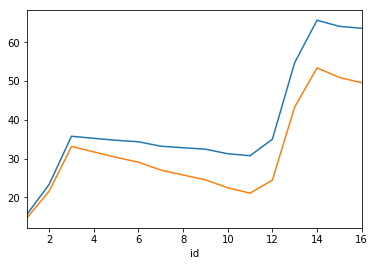

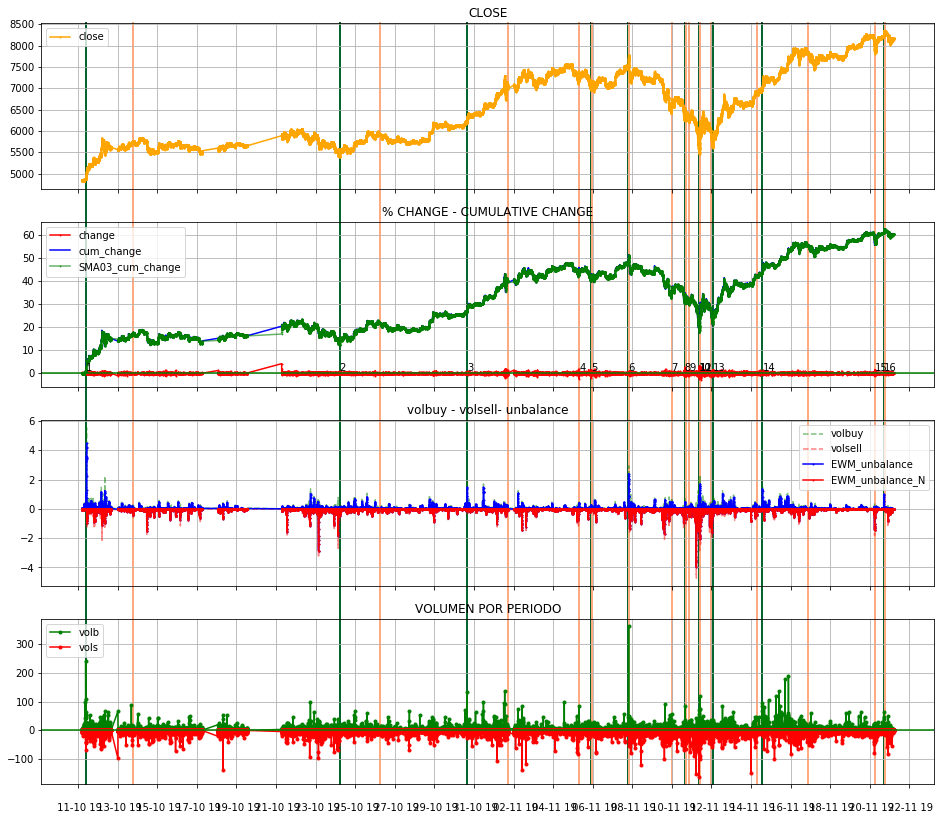

In [12]:
plotProfit()
plotHistory(plotVolume= True, plotTrades=True)

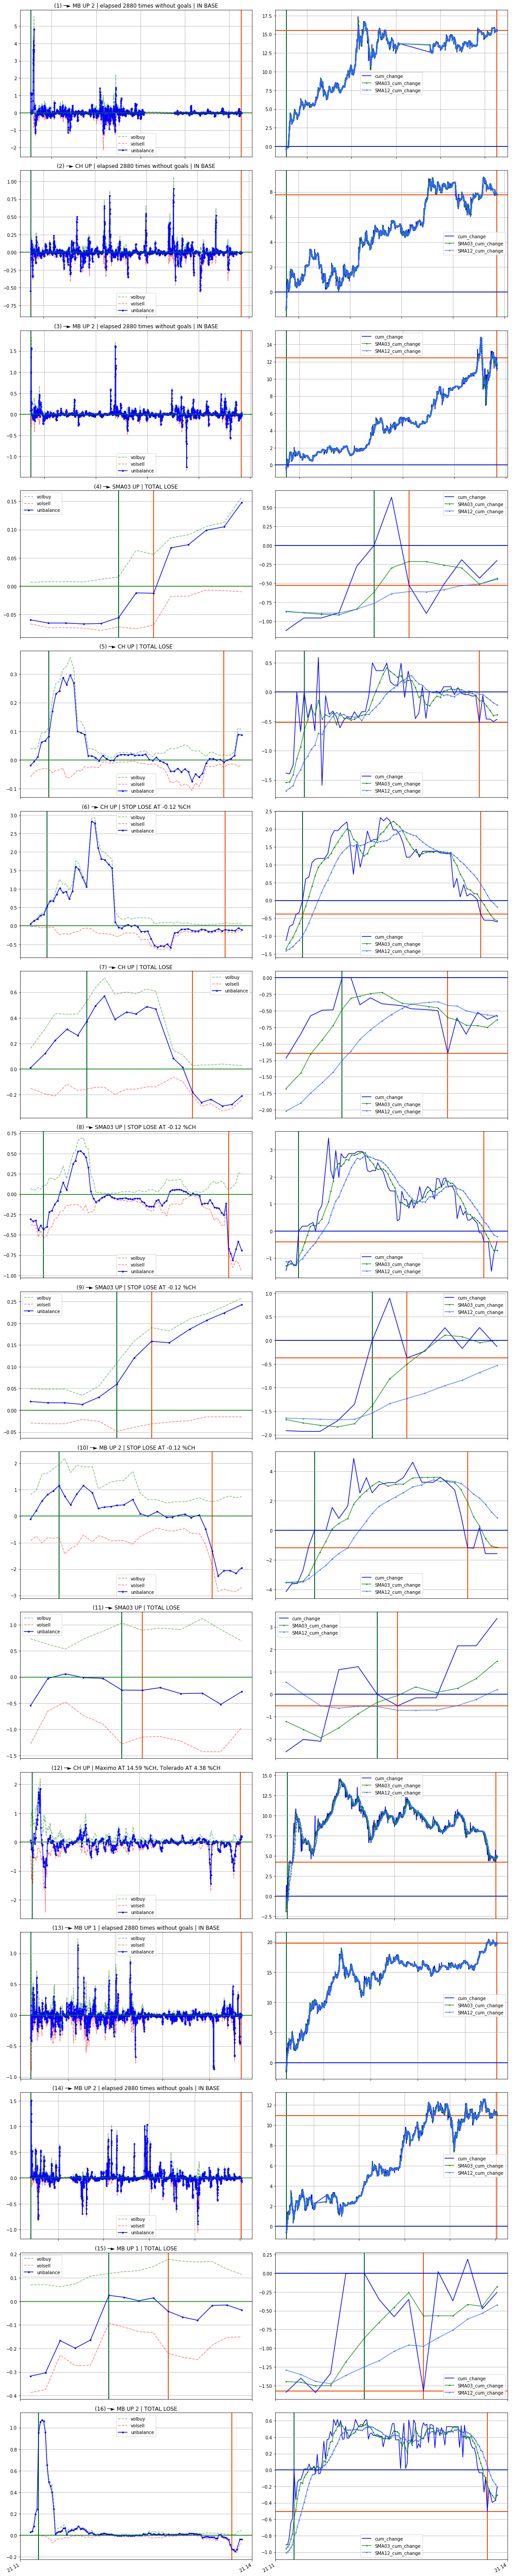

,openTime,closeTime,tradeDescription,openingCH,baseCH,targetCH,stopLoseCH,TotalLoseCH,closingCH,deltaCH,Profit,Profit_Gastos
id,,,,,,,,,,,,
1,2017-10-12 04:23:26.612857,2017-10-14 13:15:26.570998,(1) ─► MB UP 2 | elapsed 2880 times without go...,1.335923,2.215923,22.215923,1.215923,0.835923,16.869247,15.533324,15.533324,14.653324
2,2017-10-25 00:06:41.096857,2017-10-27 01:12:34.271491,(2) ─► CH UP | elapsed 2880 times without goal...,13.763578,14.643578,34.643578,13.643578,13.263578,21.539811,7.776233,23.309557,21.549557
3,2017-10-31 10:54:46.698174,2017-11-02 11:54:20.540996,(3) ─► MB UP 2 | elapsed 2880 times without go...,28.310855,29.190855,49.190855,28.190855,27.810855,40.749432,12.438577,35.748135,33.108135
4,2017-11-06 02:45:12.270965,2017-11-06 02:47:13.943924,(4) ─► SMA03 UP | TOTAL LOSE,45.050233,45.930233,65.930233,44.930233,44.550233,44.524764,-0.525469,35.222666,31.702666
5,2017-11-06 17:10:16.306706,2017-11-06 18:00:49.622202,(5) ─► CH UP | TOTAL LOSE,42.568851,43.448851,63.448851,42.448851,42.068851,42.050352,-0.518499,34.704167,30.304167
6,2017-11-08 14:20:06.778945,2017-11-08 15:20:11.944122,(6) ─► CH UP | STOP LOSE AT -0.12 %CH,49.175800,50.055800,70.055800,49.055800,48.675800,48.797751,-0.378049,34.326118,29.046118
7,2017-11-10 18:38:08.452379,2017-11-10 18:50:02.990248,(7) ─► CH UP | TOTAL LOSE,36.059842,36.939842,56.939842,35.939842,35.559842,34.917929,-1.141913,33.184205,27.024205
8,2017-11-11 10:41:29.659127,2017-11-11 12:07:14.068370,(8) ─► SMA03 UP | STOP LOSE AT -0.12 %CH,31.590593,32.470593,52.470593,31.470593,31.090593,31.191120,-0.399473,32.784732,25.744732
9,2017-11-11 16:14:27.022767,2017-11-11 16:16:33.155981,(9) ─► SMA03 UP | STOP LOSE AT -0.12 %CH,31.694533,32.574533,52.574533,31.574533,31.194533,31.323242,-0.371290,32.413442,24.493442


In [13]:
plotAllTrades()
myTrades

In [14]:
deltaVol = tradesCondensation['volb'].sum() + tradesCondensation['vols'].sum()
deltaVol

-7814.4636996899935

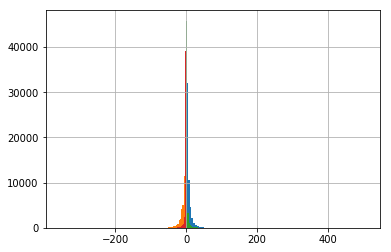

In [15]:
tradesCondensation['countb'].hist(bins=100)
tradesCondensation['counts'].hist(bins=100)
tradesCondensation['volb'].hist(bins=100)
tradesCondensation['vols'].hist(bins=100)

In [16]:
done = time.time()
elapsed = (done - start)/60
print(elapsed)

38.88857520023982


In [17]:
"""
tradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)
tradesHistory.set_index(pd.DatetimeIndex(tradesHistory['time']),inplace=True)
tradesHistory.head()
tradesHistory.tail(10)
print(tradesCondensation['volb'].last_valid_index())
# limpiar datros corrompidos
import sqlite3
conn = sqlite3.connect('krakenTeader.db')
c = conn.cursor()
data3 = str(input('Please enter name: '))
mydata = c.execute("DELETE FROM TradesHistory WHERE time=?", ("2102-05-08 07:47:11.736900",))
conn.commit()
c.close
"""

'\ntradesHistory = pd.read_sql(dbTradesHistoryTable, con=engine)\ntradesHistory.set_index(pd.DatetimeIndex(tradesHistory[\'time\']),inplace=True)\ntradesHistory.head()\ntradesHistory.tail(10)\nprint(tradesCondensation[\'volb\'].last_valid_index())\n# limpiar datros corrompidos\nimport sqlite3\nconn = sqlite3.connect(\'krakenTeader.db\')\nc = conn.cursor()\ndata3 = str(input(\'Please enter name: \'))\nmydata = c.execute("DELETE FROM TradesHistory WHERE time=?", ("2102-05-08 07:47:11.736900",))\nconn.commit()\nc.close\n'